# Normalizing Flows with Survae


This is my notebook where I play around with all things normalizing flow with pyro. I use the following packages:

* PyTorch
* Pyro
* PyTorch Lightning
* Wandb

In [ ]:
#@title Install Packages
# %%capture

!pip install --upgrade --quiet pyro-ppl tqdm wandb corner loguru pytorch-lightning lightning-bolts torchtyping einops plum-dispatch pyyaml==5.4.1 nflows
!pip install --upgrade --quiet scipy

     |████████████████████████████████| 678 kB 3.8 MB/s 
     |████████████████████████████████| 1.7 MB 37.6 MB/s 
     |████████████████████████████████| 57 kB 4.6 MB/s 
     |████████████████████████████████| 524 kB 44.2 MB/s 
     |████████████████████████████████| 282 kB 31.0 MB/s 
     |████████████████████████████████| 470 kB 42.8 MB/s 
     |████████████████████████████████| 636 kB 50.5 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 180 kB 48.7 MB/s 
     |████████████████████████████████| 140 kB 45.8 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 132 kB 49.1 MB/s 
     |████████████████████████████████| 829 kB 47.2 MB/s 
     |████████████████████████████████| 329 kB 45.7 MB/s 
     |████████████████████████████████| 1.1 MB 33.7 MB/s 
     |████████████████████████████████| 160 kB 48.6 MB/s 
     |█████████████████

In [ ]:
!git clone https://github.com/jejjohnson/survae_flows_lib.git
!pip install survae_flows_lib/. --use-feature=in-tree-build

Cloning into 'survae_flows_lib'...
remote: Enumerating objects: 761, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 761 (delta 111), reused 155 (delta 64), pack-reused 552
Receiving objects: 100% (761/761), 14.65 MiB | 12.07 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Processing ./survae_flows_lib
  Created wheel for survae: filename=survae-0.1-py3-none-any.whl size=177702 sha256=0456b967781ea0739172e6f185d65b3436b8eae6d92d68cec11f4dbc66ed77b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-dwlasnsq/wheels/67/c2/c0/86ba0f1a61a23518d230932d68534e2f505619f5a512a623b2
Successfully built survae


In [ ]:
#@title Import Packages

# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union
from pprint import pprint

# PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# Pyro Imports
import pyro.distributions as dist
import pyro.distributions.transforms as T

# PyTorch Lightning Imports
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pl_bolts.datamodules import SklearnDataModule

# wandb imports
import wandb
from tqdm.notebook import trange, tqdm
from pytorch_lightning.loggers import TensorBoardLogger


# Logging Settings
from loguru import logger
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
logger.info("Using device: {}".format(device))

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

2021-12-01 10:46:29.274 | INFO     | __main__:<module>:31 - Using device: cuda
/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


#### HelpFul Functions

##### Generate 2D Grid

In [ ]:
def generate_2d_grid(data: np.ndarray, n_grid: int = 1_000, buffer: float = 0.01) -> np.ndarray:

    xline = np.linspace(data[:, 0].min() - buffer, data[:, 0].max() + buffer, n_grid)
    yline = np.linspace(data[:, 1].min() - buffer, data[:, 1].max() + buffer, n_grid)
    xgrid, ygrid = np.meshgrid(xline, yline)
    xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)
    return xyinput

##### Plot 2D Grid

In [ ]:
from matplotlib import cm

def plot_2d_grid(X_plot, X_grid, X_log_prob):



    # Estimated Density
    cmap = cm.magma  # "Reds"
    probs = np.exp(X_log_prob)
    # probs = np.clip(probs, 0.0, 1.0)
    # probs = np.clip(probs, None, 0.0)


    cmap = cm.magma  # "Reds"
    # cmap = "Reds"

    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    h = ax[0].hist2d(
        X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
    )
    ax[0].set_title("True Density")
    ax[0].set(
        xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
        ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    )


    h1 = ax[1].scatter(
        X_grid[:, 0], X_grid[:, 1], s=1, c=probs, cmap=cmap, #vmin=0.0, vmax=1.0
    )
    ax[1].set(
        xlim=[X_grid[:, 0].min(), X_grid[:, 0].max()],
        ylim=[X_grid[:, 1].min(), X_grid[:, 1].max()],
    )
    # plt.colorbar(h1)
    ax[1].set_title("Estimated Density")


    plt.tight_layout()
    plt.show()
    return fig, ax


##### Torch 2 Numpy

In [ ]:
def torch_2_numpy(X):

    if not isinstance(X, np.ndarray):
        try:
            X = X.numpy()
        except RuntimeError:
            X = X.detach().numpy()
        except TypeError:
            X = X.detach().cpu().numpy()
    

    return X

## 2D Toy Data

In [ ]:
def get_toy_data(n_samples=1000, seed=123):
    rng = np.random.RandomState(seed=seed)

    x = np.abs(2 * rng.randn(n_samples, 1))
    y = np.sin(x) + 0.25 * rng.randn(n_samples, 1)
    data = np.hstack((x, y))

    return data

In [ ]:
X = get_toy_data(5_000, 123)

init_X = torch.Tensor(X)

In [ ]:
# # Data

# ds = CheckerboardDataset



# test = Dataset(get_toy_data(2_000, 100)[0])
# train_loader = DataLoader(train, batch_size=64, shuffle=False)
# test_loader = DataLoader(test, batch_size=256, shuffle=True)



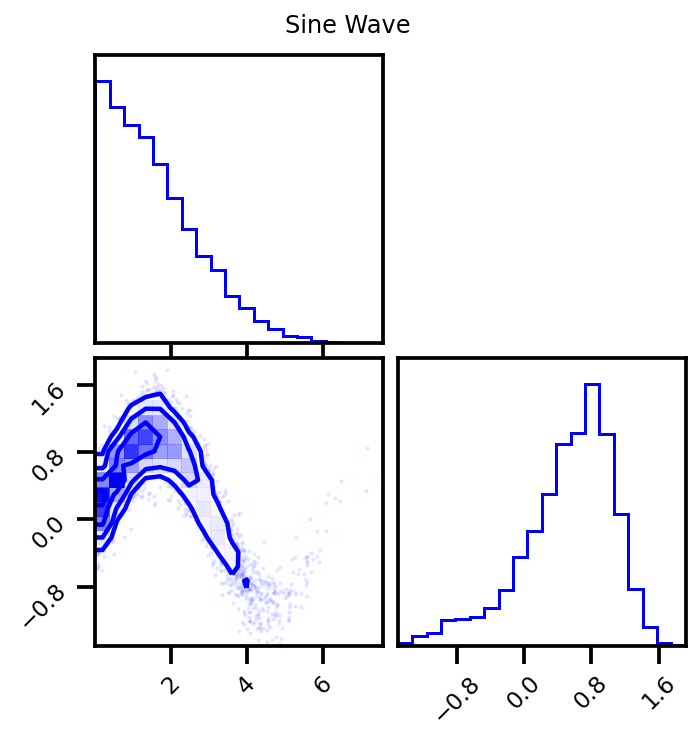

In [ ]:
fig = corner.corner(X, color="blue")
fig.suptitle("Sine Wave")
plt.show()

## Parameterized Marginal Gaussianization

In [ ]:
from survae.transforms.bijections.elementwise_nonlinear import GaussianMixtureCDF
from survae.transforms.bijections.elementwise_nonlinear import InverseGaussCDF

In [ ]:
# GaussianMixtureCDF??

In [ ]:


# marginal gaussianization
mu_bijector = GaussianMixtureCDF((2,), None, 4)

# inverse gaussian cdf
icdf_bijector = InverseGaussCDF()


with torch.no_grad():

    X_mu, _ = mu_bijector.forward(init_X)
    X_mg, _ = icdf_bijector.forward(X_mu)



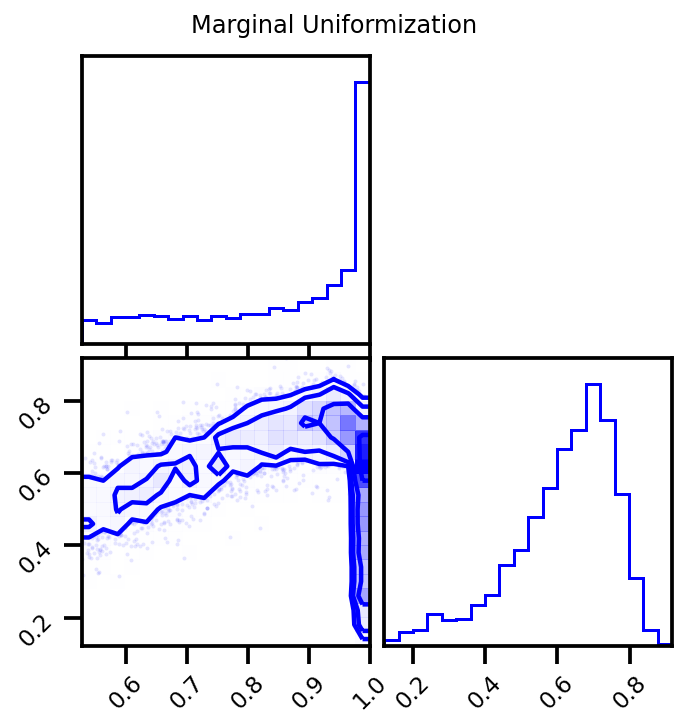

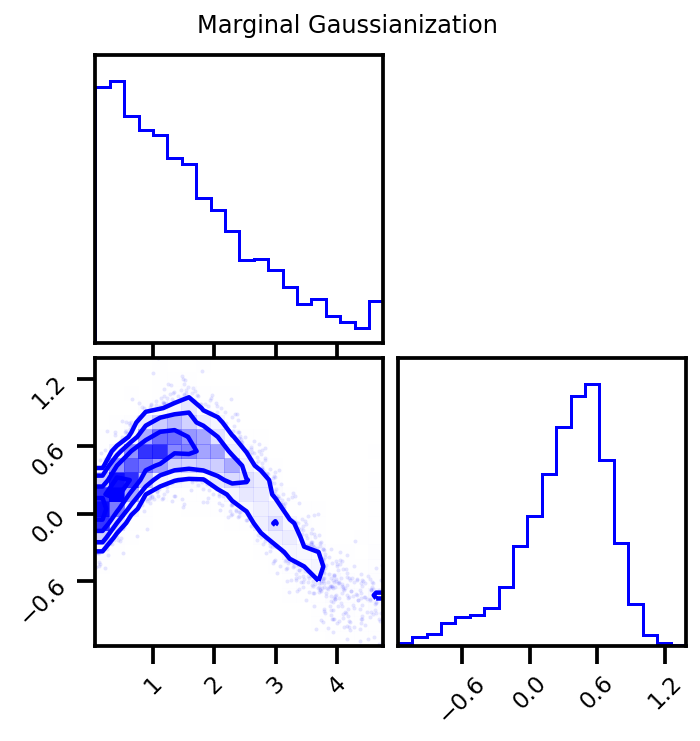

In [ ]:
fig = corner.corner(torch_2_numpy(X_mu), color="blue")
fig.suptitle("Marginal Uniformization")
plt.show()

fig = corner.corner(torch_2_numpy(X_mg), color="blue")
fig.suptitle("Marginal Gaussianization")
plt.show()

## Orthogonal Parameterization

### HouseHolder Reflections




**Algorithm**


$\mathbf{H}_k$ is reflection matrix and is defined by.

$$
\mathbf{H}_K = \mathbf{I} - 2 \frac{\mathbf{v}_k\mathbf{v}_k^\top}{||\mathbf{v}||_2^2}
$$

where $\mathbf{v}_k \in \mathbb{R}^{D}$. 

In [ ]:
num_reflections = 3
num_dimensions = 2

# create vectors, v
v_vectors = torch.ones(num_reflections, num_dimensions)

# calc denominator
squared_norms = torch.sum(v_vectors ** 2, dim=-1)

# initialize loop
Q = torch.eye(num_dimensions)

Multiply all matrices together.

$$
\mathbf{R} = \mathbf{H}_K \mathbf{H}_{K-1}\ldots \mathbf{H}_{1}
$$

where $\mathbf{R},\mathbf{H}_k \in \mathbb{R}^{D \times D}$ are orthogonal matrices. 

In [ ]:
# loop through all vectors
for v_vector, squared_norm in zip(v_vectors, squared_norms):

    # Inner product.
    temp = Q @ v_vector  

    # Outer product.
    temp = torch.ger(temp, (2.0 / squared_norm) * v_vector)  
    Q = Q - temp

In [ ]:
# check dimensions
assert Q.shape == (num_dimensions, num_dimensions)

# check it's orthogonal
assert (Q @ Q.T).all() == torch.eye(num_dimensions).all()

In [ ]:
X_r = init_X @ Q

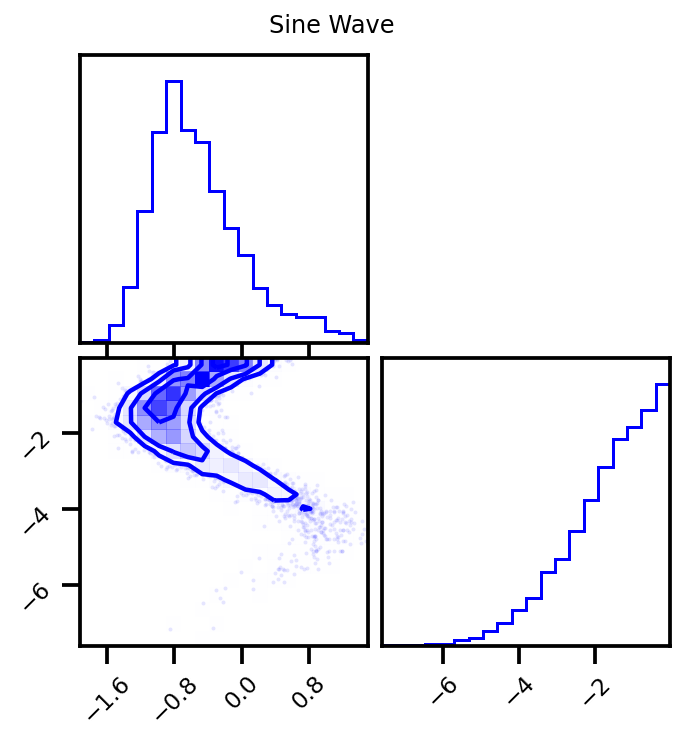

In [ ]:
fig = corner.corner(X_r.cpu().numpy(), color="blue")
fig.suptitle("Sine Wave")
plt.show()

In [ ]:
def householder_product(vectors: torch.Tensor) -> torch.Tensor:
    """
    Args:
        vectors [K,D] - q vectors for the reflections
    
    Returns:
        R [D, D] - householder reflections
    """
    num_reflections, num_dimensions = vectors.shape

    squared_norms = torch.sum(vectors ** 2, dim=-1)

    # initialize reflection
    H = torch.eye(num_dimensions)

    for vector, squared_norm in zip(vectors, squared_norms):
        temp = H @ vector  # Inner product.
        temp = torch.ger(temp, (2.0 / squared_norm) * vector)  # Outer product.
        H = H - temp

    return H



In [ ]:
# initialize vectors
v_vectors = torch.ones(num_reflections, num_dimensions)
v_vectors = torch.nn.init.orthogonal_(v_vectors)


# householder product
R = householder_product(v_vectors)

# inverse householder product
reverse_idx = torch.arange(num_reflections - 1, -1, -1)
R_inv = householder_product(v_vectors[reverse_idx])


# check the inverse
torch.testing.assert_allclose(R @ R.T, torch.eye(num_dimensions), rtol=1e-5, atol=1e-5, )

Cost - `O(KDN)`
`O(KD^2)`

### Pytorch Class

In [ ]:
from survae.transforms.bijections import Bijection

class LinearHouseholder(Bijection):
    """
    """

    def __init__(self, num_features: int, num_reflections: int = 2):
        super(LinearHouseholder, self).__init__()
        self.num_features = num_features
        self.num_reflections = num_reflections
        

        # initialize vectors param
        vectors = torch.randn(num_reflections, num_features)
        self.vectors = nn.Parameter(vectors)

        # initialize parameter to be orthogonal
        nn.init.orthogonal_(self.vectors)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # get rotation matrix
        R = householder_product(self.vectors)

        # Z = x @ R
        z = torch.mm(x, R)

        # ldj -> identity
        batch_size = x.shape[0]
        ldj = x.new_zeros(batch_size)

        return z, ldj

    def inverse(self, z):
        # get rotation matrix (in reverse)
        reverse_idx = torch.arange(self.num_reflections - 1, -1, -1)
        R = householder_product(self.vectors[reverse_idx])
        
        x = torch.mm(z, R)

        return x

In [ ]:
with torch.no_grad():
    hh_bijector = LinearHouseholder(2, 2)
    X_r, ldj = hh_bijector.forward(init_X)
    X_approx = hh_bijector.inverse(X_r)

# check the inverse
torch.testing.assert_allclose(X_approx, init_X, rtol=1e-5, atol=1e-5, )

In [ ]:
from survae.transforms.bijections.linear_orthogonal import FastHouseholder, LinearHouseholder

## Flow Model


So to have a flow model, we need two components:


---
**Base Distribution**: $p_Z = \mathbb{P}_Z$

This will describe the distribution we want in the transform domain. In this case, we will choose the uniform distribution because we are trying to uniformize our data.

---
**Bijections**: $f = f_L \circ f_{L-1} \circ \ldots \circ f_1$

The list of bijections. These are our functions which we would like to compose together to get our dataset.


In [ ]:
from survae.distributions import StandardUniform, StandardNormal
from survae.flows import Flow

# parameters
features_shape = (2,)
num_mixtures = 4
num_reflections = 2

# base distribution
base_dist = StandardNormal(features_shape)

# transforms
transforms = [
              GaussianMixtureCDF(features_shape, None, num_mixtures),
              InverseGaussCDF(),
              LinearHouseholder(features_shape[0], num_reflections)

]

# flow model
model = Flow(
    base_dist=base_dist,
    transforms=transforms
)

## Training

### Dataset

In [ ]:
# # Data
X_train = get_toy_data(5_000, 123)

train_loader = DataLoader(torch.Tensor(X_train), batch_size=128, shuffle=True)


### Loss

In [ ]:
def nll_loss(model, data):
    return - model.log_prob(data).mean()

### Pytorch-Lightning Trainer

In [ ]:
import pytorch_lightning as pl

class Learner2DPlane(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        
        # loss function
        # loss = -self.model.log_prob(batch).mean()
        loss = nll_loss(self.model, batch)
        
        self.log("train_loss", loss)
        
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def train_dataloader(self):
        return train_loader

In [ ]:
# initialize trainer
learn = Learner2DPlane(model)

In [ ]:
n_epochs = 50
# logger = TensorBoardLogger("tb_logs", name='mg_no_init')

# initialize trainer
trainer = pl.Trainer(min_epochs=1, max_epochs=n_epochs, gpus=1, enable_progress_bar=True, logger=logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### Logging

In [1]:
# %load_ext tensorboard
# %tensorboard --logdir tb_logs/

### Training

In [ ]:
# train model
trainer.fit(learn, )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Flow | 28    
-------------------------------
28        Trainable params
0         Non-trainable params
28        Total params
0.000     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory tb_logs/mg_no_init/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:408: UserWarning: The number of training samples (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

## Results


### Latent Domain

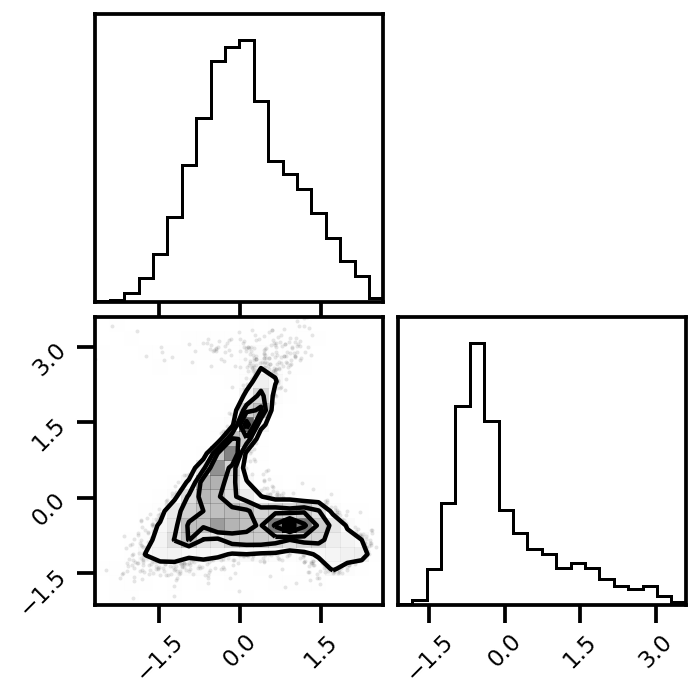

In [ ]:
with torch.no_grad():
    X_ = torch.Tensor(X)
    # X_ = X_.to(device)
    X_r, ldj = learn.model.forward_transform(X_)


fig = corner.corner(torch_2_numpy(X_r))

### Inverse

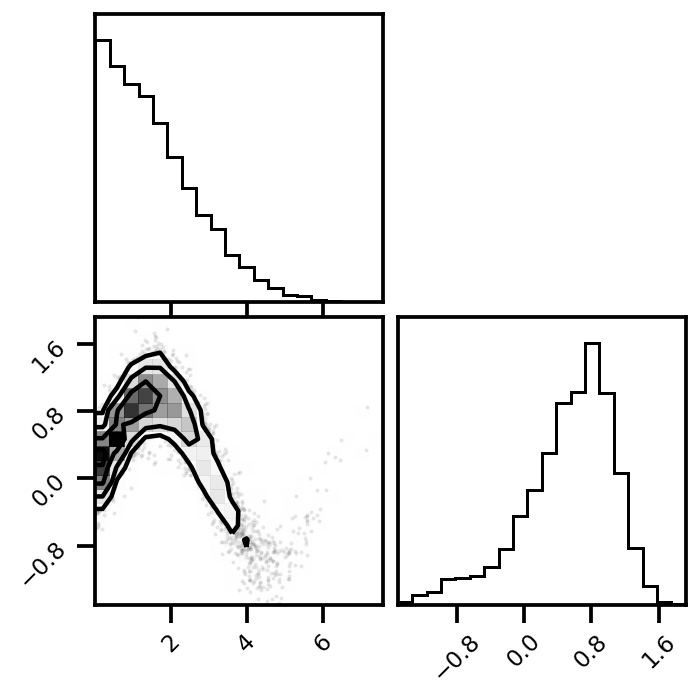

In [ ]:
with torch.no_grad():
    # X_ = X_.to(device)
    X_approx = learn.model.inverse_transform(X_r)

fig = corner.corner(torch_2_numpy(X_approx))